In [1]:
import sys
import torch
import os 
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import wandb
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage import gaussian_filter
from PIL import Image
sys.path.append('..')  

from types import SimpleNamespace
from model.model import MMC  
from src.config import Config

/raid/nlp/rajak/Multimodal/UniS-MMC/multimodal/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
args = SimpleNamespace(
    name='MMC',
    dataset='Food101',  # Adjust as per your dataset or requirement
    text_type='abstract',
    mmc='UniSMMC',
    mmc_tao=0.07,
    batch_size=32,
    lr_mm=0.001,
    min_epoch=1,
    valid_step=50,
    max_length=512,
    text_encoder='bert_base',
    image_encoder='vit_base',
    text_out=768,
    img_out=768,
    lr_mm_cls=0.001,
    mm_dropout=0.0,
    lr_text_tfm=2e-5,
    lr_img_tfm=5e-5,
    lr_img_cls=0.0001,
    lr_text_cls=5e-5,
    text_dropout=0.0,
    img_dropout=0.1,
    nplot='',
    data_dir='../datasets/',  # Ensure this path is correct in your notebook environment
    test_only=False,
    pretrained_dir='../pretrained_models',  # Adjust as necessary
    model_save_dir='Path/To/results/models',
    res_save_dir='Path/To/results/results',
    fig_save_dir='Path/To/results/imgs',
    logs_dir='Path/To/results/logs',
    local_rank=-1,
    seeds=None,
    model_path='./Path/To/results/models',
    save_model=True,
    cross_attention=False,
    text_mixup=False,
    image_mixup=False,
    image_embedding_mixup=False,
    alpha=0.2,
    multi_mixup=True,
    mixup_pct=0.33,
    lambda_mixup=0.1,
    mixup_beta=0.15,
    mixup_s_thresh=0.5,
    lr_scheduler='ReduceLROnPlateau',
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

config = Config(args)
args = config.get_config()

np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

if args.local_rank == -1:
    device = torch.device("cuda")
else:
    torch.cuda.set_device(args.local_rank)
    device = torch.device("cuda", args.local_rank)
    torch.distributed.init_process_group(backend="nccl")

args.device = device
print(args.data_dir)
args.data_dir = os.path.join(args.data_dir, args.dataset)

#args.best_model_save_path = os.path.join(args.model_save_dir, f'{args.dataset}-best-{time.strftime("%Y%m%d-%H%M%S")}.pth')

../datasets/


In [3]:
print(args.data_dir)

../datasets/Food101


In [4]:
model = MMC(args)

In [6]:
model_path = '/raid/nlp/rajak/Multimodal/UniS-MMC/Path/To/results/models/Food101-best-20240505-141217.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device=args.device)

In [7]:
def get_sentence_embedding(text, model, args):
    # Assuming the model's text_encoder has already been initialized
    tokenizer = model.text_encoder.get_tokenizer()
    encoded_input = tokenizer(text, return_tensors="pt")
    input_ids = encoded_input['input_ids'].to(device=args.device)
    print("input ids shape: ", input_ids.shape)
    attention_mask = encoded_input['attention_mask'].to(device=args.device)
    print("attention_mask shape: ", attention_mask.shape)
    token_type_ids = encoded_input.get('token_type_ids').to(device=args.device) 
    print("token_type_ids shape: ", token_type_ids.shape)
    print("attention_mask: ", print(attention_mask))
    
    with torch.no_grad():
        if 'roberta' in model.text_encoder.text_encoder:
            embeddings = model.text_encoder.forward((input_ids, None, attention_mask))
        else:
            embeddings = model.text_encoder.forward((input_ids, token_type_ids, attention_mask))

    print("embeddings shape: ", embeddings.shape)
    embeddings = embeddings.squeeze(dim = 0)
    print("embeddings shape: ", embeddings.shape)

    # # TAKING MEAN to take final embeddings
    # final_embedding= torch.mean(embeddings, dim=0)
    # print("final embedding shape: ", final_embedding.shape)

    #Taking embedding of CLS token to get the final embedding
    final_embedding = embeddings[0, :]
    print("final embedding shape: ", final_embedding.shape)

    return final_embedding

In [8]:
def get_image_embedding(image_path, model, args):
    image = Image.open(image_path).convert('RGB')
    feature_extractor = model.image_encoder.get_tokenizer()  # Ensure this method is properly returning the feature extractor
    inputs = feature_extractor(images=image, return_tensors="pt")
    pixel_values = inputs['pixel_values']

    model.eval()
    pixel_values = pixel_values.to(args.device)  

    # Extract embeddings
    with torch.no_grad():
        image_embeddings = model.image_encoder(pixel_values)
    
    print("image embeddings shape:", image_embeddings.shape)
    image_embeddings = image_embeddings.squeeze()
    print("image embeddings shape:", image_embeddings.shape)

    # #Taking final embedding as mean embedding
    # final_embedding= torch.mean(image_embeddings, dim=0)
    # print("final embedding shape: ", final_embedding.shape)

    # Taking final embedding as cls embedding
    final_embedding = image_embeddings[0,:]
    print("final embedding shape: ", final_embedding.shape)

    return final_embedding

In [9]:
def get_patch_embeddings(image, model, args):
    feature_extractor = model.image_encoder.get_tokenizer()  
    inputs = feature_extractor(images=image, return_tensors="pt")
    pixel_values = inputs['pixel_values']

    model.eval()
    pixel_values = pixel_values.to(args.device)  

    # Extract embeddings
    with torch.no_grad():
        image_embeddings = model.image_encoder(pixel_values)
    
    print("image embeddings shape:", image_embeddings.shape)
    return image_embeddings.squeeze()  

In [10]:
def compute_attention_scores(patch_embeddings, word_embedding):
    # Normalize the embeddings
    patch_embeddings = patch_embeddings / torch.norm(patch_embeddings, dim=1, keepdim=True)
    word_embedding = word_embedding / torch.norm(word_embedding)
    
    attention_scores = torch.abs(torch.matmul(patch_embeddings, word_embedding.unsqueeze(-1)).squeeze(-1))
    return attention_scores

In [21]:
word_embedding = get_sentence_embedding("french fries", model, args)

input ids shape:  torch.Size([1, 4])
attention_mask shape:  torch.Size([1, 4])
token_type_ids shape:  torch.Size([1, 4])
tensor([[1, 1, 1, 1]], device='cuda:0')
attention_mask:  None
embeddings shape:  torch.Size([1, 4, 768])
embeddings shape:  torch.Size([4, 768])
final embedding shape:  torch.Size([768])


In [22]:
image_path = '/raid/nlp/rajak/Multimodal/UniS-MMC/datasets/Food101/images/train/french_fries/french_fries_1.jpg'
image_embedding = get_image_embedding(image_path, model, args) 
image = Image.open(image_path).convert('RGB')
patch_embeddings = get_patch_embeddings(image,model,args) 
print(patch_embeddings.shape)

image embeddings shape: torch.Size([1, 197, 768])
image embeddings shape: torch.Size([197, 768])
final embedding shape:  torch.Size([768])
image embeddings shape: torch.Size([1, 197, 768])
torch.Size([197, 768])


In [23]:
attention_scores = compute_attention_scores(patch_embeddings,word_embedding)
print(attention_scores.shape)


torch.Size([197])


In [24]:
def visualize_attention_map(image_path, attention_scores, patch_size=16):
    image = Image.open(image_path)
    img_width, img_height = image.size


    num_patches_side = int(np.sqrt(len(attention_scores) - 1))  
    attention_scores_2d = attention_scores[1:].view(num_patches_side, num_patches_side).detach().cpu().numpy()  

    # Create the heatmap
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)

    # Overlay the heatmap
    heatmap = ax.imshow(np.kron(attention_scores_2d, np.ones((patch_size, patch_size))),
                        cmap='hot', alpha=0.5, extent=(0, img_width, img_height, 0), interpolation='bilinear')

    # Add color bar
    cbar = plt.colorbar(heatmap)
    cbar.set_label('Attention Score')

    plt.axis('off')
    plt.show()

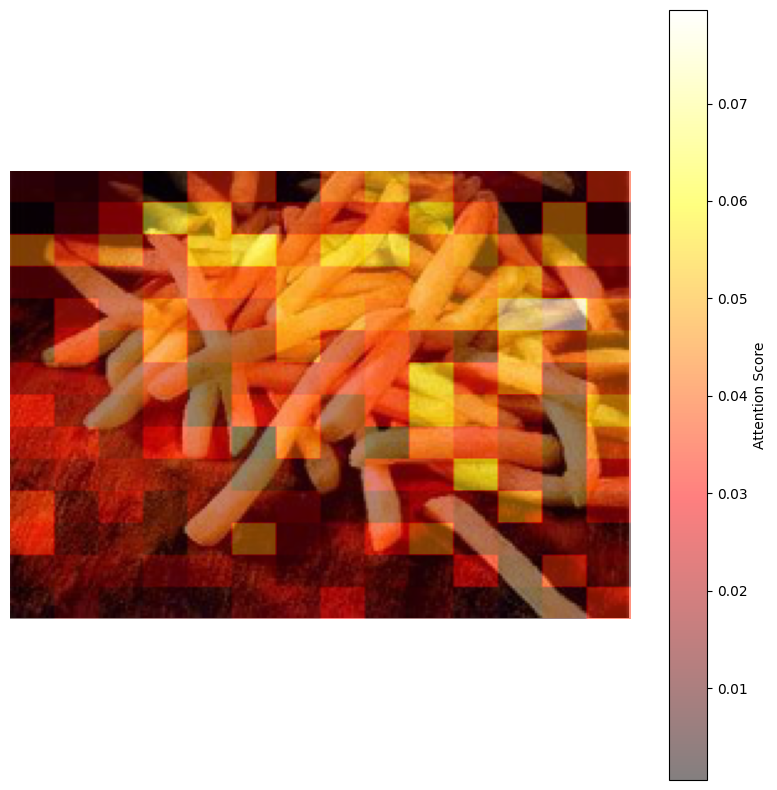

In [25]:
visualize_attention_map(image_path, attention_scores)